# Convolutional Autoencoder

In [1]:
%matplotlib inline

import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [3]:
features = np.empty((0,32,32,3))
labels = []
for i in range(1, 6):
    ft, lb = load_cifar10_batch('cifar-10', i)
    features = np.concatenate((features, ft))
    labels += lb
x_train = features / 255

In [4]:
ft, lb = load_cifar10_batch('cifar-10', 6)
x_test = ft / 255

In [5]:
print (x_train.shape)
print (len(labels))

(50000, 32, 32, 3)
50000


In [6]:
print (x_test.shape)

(10000, 32, 32, 3)


Label: 4


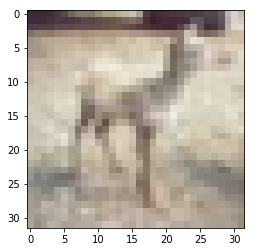

In [7]:
idx = random.randint(1, len(labels))
print ("Label: {}".format(labels[idx]))
img = x_train[idx]
plt.imshow(img.reshape((32, 32, 3)))

In [8]:
learning_rate = 0.001
# Input and target placeholders

inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv1.shape)
# Now 32x32x64
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
print(maxpool1.shape)
# Now 16x16x64
conv2 = tf.layers.conv2d(maxpool1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv2.shape)
# Now 16x16x128
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
print(maxpool2.shape)
# Now 8x8x128
conv3 = tf.layers.conv2d(maxpool2, 256, (3,3), padding='same', activation=tf.nn.relu)
print(conv3.shape)
# Now 8x8x256
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
print(encoded.shape)
# Now 4x4x256

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (8,8))
print(upsample1.shape)
# Now 8x8x256
conv4 = tf.layers.conv2d(upsample1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv4.shape)
# Now 8x8x128
upsample2 = tf.image.resize_nearest_neighbor(conv4, (16,16))
print(upsample2.shape)
# Now 16x16x128
conv5 = tf.layers.conv2d(upsample2, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv5.shape)
# Now 16x16x64
upsample3 = tf.image.resize_nearest_neighbor(conv5, (32,32))
print(upsample3.shape)
# Now 32x32x64
logits = tf.layers.conv2d(upsample3, 3, (3,3), padding='same', activation=None)
print(logits.shape)
# Now 32x32x3

#logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#print(logits.shape)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='output')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(?, 32, 32, 64)
(?, 16, 16, 64)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 8, 8, 256)
(?, 4, 4, 256)
(?, 8, 8, 256)
(?, 8, 8, 128)
(?, 16, 16, 128)
(?, 16, 16, 64)
(?, 32, 32, 64)
(?, 32, 32, 3)


## Training

In [9]:
sess = tf.Session()

In [ ]:
def get_batch(ii, batch_size):
    begin = ii * batch_size
    end = (ii+1) * batch_size
    return x_train[begin:end], labels[begin:end]

In [ ]:
epochs = 20
train_size = features.shape[0]
batch_size = 128
total_batches = train_size//batch_size

sess.run(tf.global_variables_initializer())
for e in range(epochs):    
    for ii in range(total_batches):
        batch = get_batch(ii, batch_size)
        imgs = batch[0].reshape((-1, 32, 32, 3))        
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
        if ii % 100 == 0:
            print("Epoch: {}/{} Step: {}/{} ...".format(e+1, epochs, ii, total_batches),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20 Step: 0/390 ... Training loss: 0.6930
Epoch: 1/20 Step: 1/390 ... Training loss: 0.6926
Epoch: 1/20 Step: 2/390 ... Training loss: 0.6938
Epoch: 1/20 Step: 3/390 ... Training loss: 0.6878
Epoch: 1/20 Step: 4/390 ... Training loss: 0.6859
Epoch: 1/20 Step: 5/390 ... Training loss: 0.6791
Epoch: 1/20 Step: 6/390 ... Training loss: 0.6657
Epoch: 1/20 Step: 7/390 ... Training loss: 0.6648
Epoch: 1/20 Step: 8/390 ... Training loss: 0.7043
Epoch: 1/20 Step: 9/390 ... Training loss: 0.6728
Epoch: 1/20 Step: 10/390 ... Training loss: 0.6662
Epoch: 1/20 Step: 11/390 ... Training loss: 0.6506
Epoch: 1/20 Step: 12/390 ... Training loss: 0.6569
Epoch: 1/20 Step: 13/390 ... Training loss: 0.6637
Epoch: 1/20 Step: 14/390 ... Training loss: 0.6590
Epoch: 1/20 Step: 15/390 ... Training loss: 0.6524
Epoch: 1/20 Step: 16/390 ... Training loss: 0.6585
Epoch: 1/20 Step: 17/390 ... Training loss: 0.6442
Epoch: 1/20 Step: 18/390 ... Training loss: 0.6312
Epoch: 1/20 Step: 19/390 ... Training los

Epoch: 1/20 Step: 160/390 ... Training loss: 0.5753
Epoch: 1/20 Step: 161/390 ... Training loss: 0.5758
Epoch: 1/20 Step: 162/390 ... Training loss: 0.5790
Epoch: 1/20 Step: 163/390 ... Training loss: 0.5656
Epoch: 1/20 Step: 164/390 ... Training loss: 0.5654
Epoch: 1/20 Step: 165/390 ... Training loss: 0.5813
Epoch: 1/20 Step: 166/390 ... Training loss: 0.5835
Epoch: 1/20 Step: 167/390 ... Training loss: 0.5753
Epoch: 1/20 Step: 168/390 ... Training loss: 0.5733
Epoch: 1/20 Step: 169/390 ... Training loss: 0.5711
Epoch: 1/20 Step: 170/390 ... Training loss: 0.5720
Epoch: 1/20 Step: 171/390 ... Training loss: 0.5664
Epoch: 1/20 Step: 172/390 ... Training loss: 0.5778
Epoch: 1/20 Step: 173/390 ... Training loss: 0.5728
Epoch: 1/20 Step: 174/390 ... Training loss: 0.5917
Epoch: 1/20 Step: 175/390 ... Training loss: 0.5692
Epoch: 1/20 Step: 176/390 ... Training loss: 0.5743
Epoch: 1/20 Step: 177/390 ... Training loss: 0.5776
Epoch: 1/20 Step: 178/390 ... Training loss: 0.5756
Epoch: 1/20 

Epoch: 1/20 Step: 318/390 ... Training loss: 0.5763
Epoch: 1/20 Step: 319/390 ... Training loss: 0.5633
Epoch: 1/20 Step: 320/390 ... Training loss: 0.5694
Epoch: 1/20 Step: 321/390 ... Training loss: 0.5708
Epoch: 1/20 Step: 322/390 ... Training loss: 0.5702
Epoch: 1/20 Step: 323/390 ... Training loss: 0.5756
Epoch: 1/20 Step: 324/390 ... Training loss: 0.5743
Epoch: 1/20 Step: 325/390 ... Training loss: 0.5658
Epoch: 1/20 Step: 326/390 ... Training loss: 0.5765
Epoch: 1/20 Step: 327/390 ... Training loss: 0.5627
Epoch: 1/20 Step: 328/390 ... Training loss: 0.5747
Epoch: 1/20 Step: 329/390 ... Training loss: 0.5821
Epoch: 1/20 Step: 330/390 ... Training loss: 0.5736
Epoch: 1/20 Step: 331/390 ... Training loss: 0.5781
Epoch: 1/20 Step: 332/390 ... Training loss: 0.5681
Epoch: 1/20 Step: 333/390 ... Training loss: 0.5704
Epoch: 1/20 Step: 334/390 ... Training loss: 0.5611
Epoch: 1/20 Step: 335/390 ... Training loss: 0.5710
Epoch: 1/20 Step: 336/390 ... Training loss: 0.5680
Epoch: 1/20 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 32, 32, 3))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()

## Denoising

In [ ]:
learning_rate = 0.001

inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv1.shape)
# Now 32x32x64
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
print(maxpool1.shape)
# Now 16x16x64
conv2 = tf.layers.conv2d(maxpool1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv2.shape)
# Now 16x16x128
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
print(maxpool2.shape)
# Now 8x8x128
conv3 = tf.layers.conv2d(maxpool2, 256, (3,3), padding='same', activation=tf.nn.relu)
print(conv3.shape)
# Now 8x8x256
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
print(encoded.shape)
# Now 4x4x256

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (8,8))
print(upsample1.shape)
# Now 8x8x256
conv4 = tf.layers.conv2d(upsample1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv4.shape)
# Now 8x8x128
upsample2 = tf.image.resize_nearest_neighbor(conv4, (16,16))
print(upsample2.shape)
# Now 16x16x128
conv5 = tf.layers.conv2d(upsample2, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv5.shape)
# Now 16x16x64
upsample3 = tf.image.resize_nearest_neighbor(conv5, (32,32))
print(upsample3.shape)
# Now 32x32x64
logits = tf.layers.conv2d(upsample3, 3, (3,3), padding='same', activation=None)
print(logits.shape)
# Now 32x32x3

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='output')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 128
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(total_batches):
        batch = get_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 32, 32, 3))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 32, 32, 3))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((32, 32, 3)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)